# Elo for tennisrungs

## Crawl tennisrungs.com and scrape all info

In [3]:
import re
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps['hsv']


# LEAGUE_ID = "singles-2.0-3.0/144208065"
LEAGUE_ID = "singles-3.0-3.5/143889747"
# LEAGUE_ID = "singles-3.5-4.0/143820677"

def parse_table(table):
    '''Parse table from scraped html.'''
    data = []
    for row in table.find_all('tr'):
        row_data = []
        for cell in row.find_all('td'):
            row_data.append(cell.text.strip())
            if cell.a is not None:
                row_data.append(cell.a['href'])
        data.append(row_data)
    return data[1:]
url_base = "https://app.tennisrungs.com"
url = f"{url_base}/atc/tennis-ladders/{LEAGUE_ID}"
req = requests.get(url)

soup = BeautifulSoup(req.text, "html.parser")
table = soup.find('table', {'id': 'ladderrankings'})
data = parse_table(table)
df_player = pd.DataFrame([(x[1], x[2], x[6]) for x in data])
df_player.columns = ['name', 'link', 'points']
df_player['player_id'] = df_player['link'].apply(lambda x: x.split('teamId=')[-1])
df_player.head()

,name,link,points,player_id
0,Stefano Cosentino,/Public/PlayerMatches/?teamId=144232167,115.00,144232167
1,Abhimanyu Yadav,/Public/PlayerMatches/?teamId=144264147,113.00,144264147
2,Shreyas Seshadri,/Public/PlayerMatches/?teamId=144264139,113.00,144264139
3,Pablo Caballero,/Public/PlayerMatches/?teamId=144367225,112.00,144367225
4,Devank Agarwal,/Public/PlayerMatches/?teamId=144569465,110.00,144569465


In [5]:
def calculate_result_stats(s, add_tb=False, option=1):
    '''Extract winning stats.'''
    for lbl in ['Forfeit', 'NoShow', 'CourtTimeExpired']:
        s = s.replace(lbl, '')
    rex = r'([0-9]{1,2}\-[0-9]{1,2})?\s?(\(([0-9]{1,2}\-[0-9]{1,2})\))?'
    num, den = 0, 0
    for g in s.split(','):
        res, _, tb = re.match(rex, g.strip()).groups()
        if res is not None:
            a, b = res.split('-')
            num += int(a)
            den += int(a) + int(b)
            # Ignore TB score, since the game has already been recorded
        else:
            # Super TB (no res)
            if not add_tb:
                continue
            if option == 1:
                # Option 1: Roughly equate 1 TB won to 2.5 games
                num += 2.5
                den += 2.5
            if option == 2:
                # Option 2: Roughly equate 5 points to 1 game won
                a, b = res.split('-')
                num += int(a) // 5
                den += int(a) // 5 + int(b) // 5
    return num/den if den>0 else 0

##################
# Create history by crawling all pages and logging results (will be deduplicated later)
results = []
for idx, row in df_player.iterrows():
    req = requests.get(f"{url_base}{row['link']}")
    soup = BeautifulSoup(req.text, "html.parser")
    table = soup.find('table', {'id': 'challenges'})
    if table is not None:
        res_ = parse_table(table)
        res_ = [[row['player_id'], row['name']] + r for r in res_]
        results.append(res_)

##################
# Cleanup the logs
df = pd.DataFrame([y for x in results for y in x])
df.columns = ['player_a_id', 'player_a',  'date', 'player_b', 'link', 'res', 'score']
# Add players that dropped fromt the challenge:
df['player_b_id'] = df['link'].apply(lambda x: x.split('teamId=')[-1])
for _, row in df.iterrows():
    if row['player_b_id'] not in df_player['player_id'].values:
        print(f'\tINFO: Adding dropped-player "{row["player_b"]}" to list.')
        df_player.loc[len(df_player.index)] = [row['player_b'], row['link'], None, row['player_b_id']] 
df['player_b'] = df['player_b_id'].apply(lambda x: df_player[df_player['player_id']==x].iloc[0]['name'])
# Add useful fields:
df['winner'] = df['res'].apply(lambda x: 'a' if x=='W' else 'b')
df['loser'] = df['res'].apply(lambda x: 'b' if x=='W' else 'a')
df['winner_name'] = df.apply(lambda x: x[f'player_{x["winner"]}'], axis=1)
# Create winning stats, maybe useful in the future:
df['ratio_win'] = df['score'].apply(lambda x: calculate_result_stats(x))
df['ratio_win'] = df.apply(lambda x: x['ratio_win'] if x['res']=='W' else 1-x['ratio_win'], axis=1)
df['ratio_win_tb'] = df['score'].apply(lambda x: calculate_result_stats(x, add_tb=True))
df['ratio_win_tb'] = df.apply(lambda x: x['ratio_win_tb'] if x['res']=='W' else 1-x['ratio_win_tb'], axis=1)
# Unique identifier for a match:
df['match_uid'] = df.apply(lambda d: f"{d['date'].replace('/', '')}_{'_'.join(sorted(d[['player_a_id', 'player_b_id']]))}", axis=1)
# Sort chronologically:
df['date'] = pd.to_datetime(df['date'])
df['ts'] = df['date'].apply(lambda x: pd.Timestamp(x).timestamp())
df['week_nr'] = df['date'].dt.isocalendar().week
df = df.sort_values('ts').reset_index(drop=True)
df = df[['date', 'player_a', 'player_a_id', 'player_b', 'player_b_id', 'winner', 'loser', 'score',
         'ratio_win', 'ratio_win_tb', 'match_uid', 'winner_name', 'ts', 'week_nr']] # df.drop(columns=['res'])
# Deduplicate logs:
df = df[~df.duplicated(subset=['match_uid'], keep='first')].reset_index(drop=True)

print(f'''There are {len(df_player)} players in this league and a total of {len(df)} matched played.''')
df.head(10)

,date,player_a,player_a_id,player_b,player_b_id,winner,loser,score,ratio_win,ratio_win_tb,match_uid,winner_name,ts,week_nr
0,2023-09-01,Kevin Sung,144232204,Stanley Tseng,144232148,b,a,"6-4,0-0Forfeit",0.400000,0.400000,912023_144232148_144232204,Stanley Tseng,1.693526e+09,35
1,2023-09-01,Jiwoong Lee,144232161,Woojay Jeon,144232129,a,b,"6-3, 6-1",0.750000,0.750000,912023_144232129_144232161,Jiwoong Lee,1.693526e+09,35
2,2023-09-02,Shreyas Seshadri,144264139,Manojkumar Chinnakonda,144232130,a,b,"7-5,6-4",0.590909,0.590909,922023_144232130_144264139,Shreyas Seshadri,1.693613e+09,35
3,2023-09-02,Yu Luo,144232138,Xin Shen,144232093,a,b,"6-4, 6-1",0.705882,0.705882,922023_144232093_144232138,Yu Luo,1.693613e+09,35
4,2023-09-02,Woojay Jeon,144232129,Xin Shen,144232093,b,a,"7-5, 6-0",0.277778,0.277778,922023_144232093_144232129,Xin Shen,1.693613e+09,35
5,2023-09-02,Pablo Caballero,144367225,Rafael Alencar,144232228,a,b,"6-0,6-1",0.923077,0.923077,922023_144232228_144367225,Pablo Caballero,1.693613e+09,35
6,2023-09-02,Jiwoong Lee,144232161,Sean Kremenetski,144298161,a,b,"7-5,6-2",0.650000,0.650000,922023_144232161_144298161,Jiwoong Lee,1.693613e+09,35
7,2023-09-04,Xin Zheng,144232234,Shreyas Seshadri,144264139,a,b,"6-3,6-4",0.631579,0.631579,942023_144232234_144264139,Xin Zheng,1.693786e+09,36
8,2023-09-04,Sean Kremenetski,144298161,Colleen Rhoades,144232233,b,a,"6-3, 3-6, (10-3)",0.500000,0.439024,942023_144232233_144298161,Colleen Rhoades,1.693786e+09,36
9,2023-09-04,Gary Chang,144367248,Jay Cai,144232122,a,b,"6-2,6-2",0.750000,0.750000,942023_144232122_144367248,Gary Chang,1.693786e+09,36


## Compute the elo score for all players

In [6]:
from scipy.stats import norm
import re


class ComputeElo:
	'''
	Class to implement the Elo score_elo. Formulas & parameters are taken from:
	https://en.wikipedia.org/wiki/Elo_score_elo_system
	'''
	def __init__(self, k=20, g=5):
		self.elo = {}
		self.usta_scores = {}
		self.elo_history = []
		self.players = {}
		self.k = k  # this should be >20 when we have small number of matches
		self.g = g  # dunno about this

	def add_players(self, names, score_elo=1500):
		for name in names:
			self.players[name] = Player(name=name, score_elo=score_elo)
			self.elo[name] = score_elo

	def expected_outcome(self, p1, p2, a=400.0, b=10.0):
		return 1 / (b**((p2 - p1) / a) + 1)

	def log_result(self, winner, loser, min_=100):
		exp_result = self.expected_outcome(self.elo[winner], self.elo[loser])
		kg = self.k * self.g
		self.elo[winner] = max(min_, self.elo[winner] + kg * (1 - exp_result))
		self.elo[loser]  = max(min_, self.elo[loser]  + kg * (exp_result - 1))
		self.elo_history.append(list(self.elo.values()))

		self.update_player_stats(winner, result='W')
		self.update_player_stats(loser,  result='L')

	def update_player_stats(self, name, result):
		self.players[name].score_elo = self.elo[name]
		self.players[name].results += result

	def rankings(self, score='elo'):
		scores = self.usta_scores if score=='usta' else self.elo
		return sorted(scores.items(), key=lambda item: -item[1])

	def top(self, N=None, verbose=False, score='elo'):
		rankings = self.rankings(score=score)[:N or -1]
		if verbose:
			for n, (a, b) in enumerate(rankings, 1):
				print(f"#{n} {b:.0f} {a}")
		return rankings

	def generate_history(self):
		df = pd.DataFrame(self.elo_history)
		df.columns = self.elo.keys()
		return df
	
	def compute_usta_scores(self, low_cutoff, hig_cutoff, pc=0.95, map_to=0.5, compress=True):

		score_usta = np.array(np.array(list(self.elo.values())), copy=True)
		score_usta /= score_usta.std()
		score_usta -= score_usta.mean()
		score_usta += low_cutoff + (hig_cutoff - low_cutoff) / 2.0

		cutoff_up = norm.ppf(pc, loc=score_usta.mean(), scale=score_usta.std())
		scale = cutoff_up - score_usta.mean()

		mu = score_usta.mean()
		score_usta -= mu
		score_usta /= scale
		score_usta += mu

		if compress:
			x_ = score_usta[score_usta>hig_cutoff]
			min_ = x_.min()
			x_ = np.log10(x_ / min_)
			x_ = (x_ / x_.max() * map_to) + min_
			score_usta[score_usta>hig_cutoff] = x_

			x_ = score_usta[score_usta<low_cutoff]
			max_ = x_.max()
			x_ = 10**(x_ / max_ - 1)  #np.log10(vals / v_m)
			x_ -= x_.min()
			x_ = (low_cutoff-map_to) + x_ / x_.max() * map_to
			score_usta[score_usta<low_cutoff] = x_
		
		for k, name in enumerate(self.elo.keys()):
			self.players[name].score_usta = score_usta[k]
			self.usta_scores[name] = score_usta[k]


class Player:
	'''Class for the Player.'''
	def __init__(self, name, score_elo):
		self.name = name
		self.score_elo = score_elo
		self.score_usta = None
		self.results = ''
		self.points = None

	@property
	def last_result(self):
		return self.results[-1]

Listing all 89 players and their ELO/USTA scores:
 #	ELO	USTA	name
(1)	2060	4.03	Stefano Cosentino
(2)	1850	3.85	Pablo Caballero
(3)	1828	3.83	Abhimanyu Yadav
(4)	1781	3.79	Shreyas  Seshadri
(5)	1771	3.77	Donald Zhu
(6)	1646	3.64	Devank Agarwal
(7)	1623	3.61	Hong Zeng
(8)	1606	3.59	Xin Zheng
(9)	1601	3.59	Manojkumar Chinnakonda
(10)	1587	3.57	Gary Chang


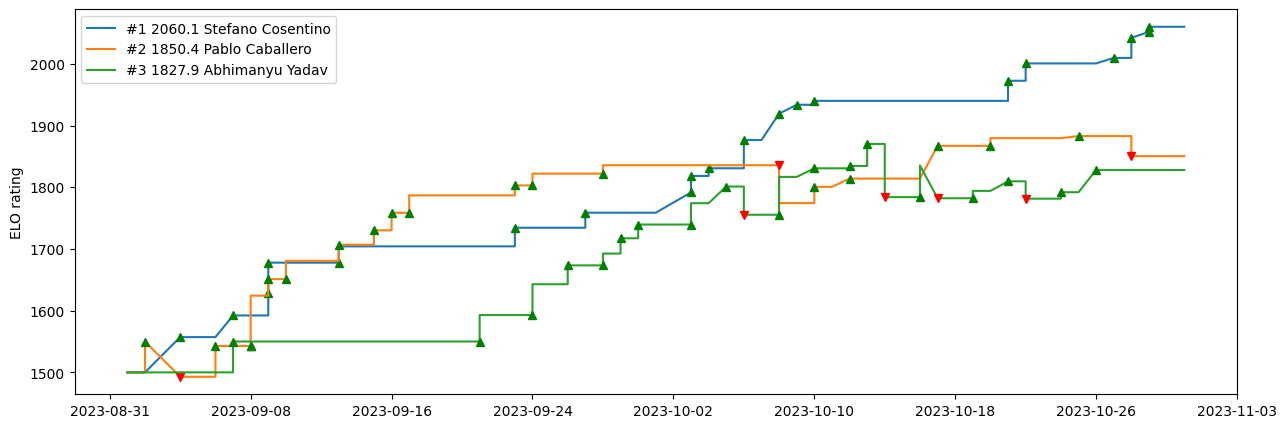

In [7]:
CE = ComputeElo()
CE.add_players(df_player['name'], score_elo=1500)

# Iterate through all records and update elo's
for idx, row in df.sort_values('ts').iterrows():
    CE.log_result(winner=row[f'player_{row["winner"]}'],
                  loser=row[f'player_{row["loser"]}'])

# Compute USTA scores from elo's
low_cutoff, hig_cutoff = map(float, re.findall(r'([1-5]\.[0,5])\-([1-5]\.[0,5])', LEAGUE_ID)[0])
CE.compute_usta_scores(low_cutoff, hig_cutoff, pc=0.95, map_to=0.5, compress=True)

# Print ranks and scores
rankings = CE.top(N=10, verbose=False, score='elo')
print(f'Listing all {len(df_player)} players and their ELO/USTA scores:\n #\tELO\tUSTA\tname')
for n, (name, elo) in enumerate(rankings, 1):
    print(f"({n})\t{elo:.0f}\t{CE.usta_scores[name]:.2f}\t{name}")

# Plot progression
dfh = CE.generate_history()
f, ax = plt.subplots(1, 1, figsize=(15,5))
time_label = 'date'
for pos, (name, elo) in enumerate(CE.top(3), 1):
    ax.plot(df[time_label], dfh[name], '-', label=f"#{pos} {elo:.1f} {name[:17]}")
    for idx, row in df.iterrows():
        if name!=row['player_a'] and name!=row['player_b']:
            continue
        sym = '^g' if row["winner_name"]==name else 'vr'
        plt.plot(row[time_label], dfh[name].iloc[idx], sym)
ax.xaxis.set_major_locator(plt.MaxNLocator(10)); ax.set_ylabel('ELO rating'); ax.legend();

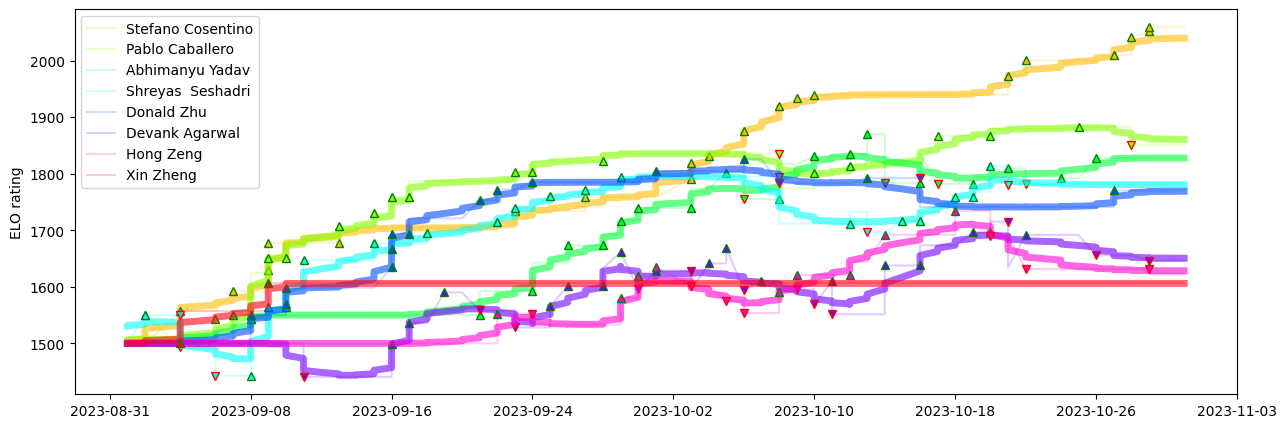

In [8]:
f, ax = plt.subplots(1, 1, figsize=(15,5))
time_label = 'date'
for k, name in enumerate([name for name, _ in CE.top(8)], 1):
    ax.plot(df[time_label], dfh[name], '-', color=cmap(k/8), label=name[:17], alpha=.2);
    ax.plot(df[time_label], gaussian_filter1d(dfh[name], sigma=4), '-', color=cmap(k/8), lw=5, alpha=.6);
    for idx, row in df.iterrows():
        if name!=row['player_a'] and name!=row['player_b']:
            continue
        sym = '^g' if row["winner_name"]==name else 'vr'
        plt.plot(row[time_label], dfh[name].iloc[idx], sym, markerfacecolor=cmap(k/8))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylabel('ELO rating'); ax.legend();

### Investigate conversion from ELO to USTA scores

Main idea:
- Assume each group is distributed normally and centered to the USTA range; eg, the average player in the 3.0-3.5 group has a USTA score of 3.25.
- Assume that at the end of the tournament, top 5% will move up, bottom 5% will move down (actual numbers may vary, this is just for a completely filled in distribution)
- The rest is just math to shift from ELO to USTA score distribution
- Finally, apply a compression to ensure that all values are at best +/- 0.5 USTA levels from the range limits; eg for 3.0-3.5 group, no score smaller than 2.5 or greater than 4.0 is generated. This compression is a power of 10. 

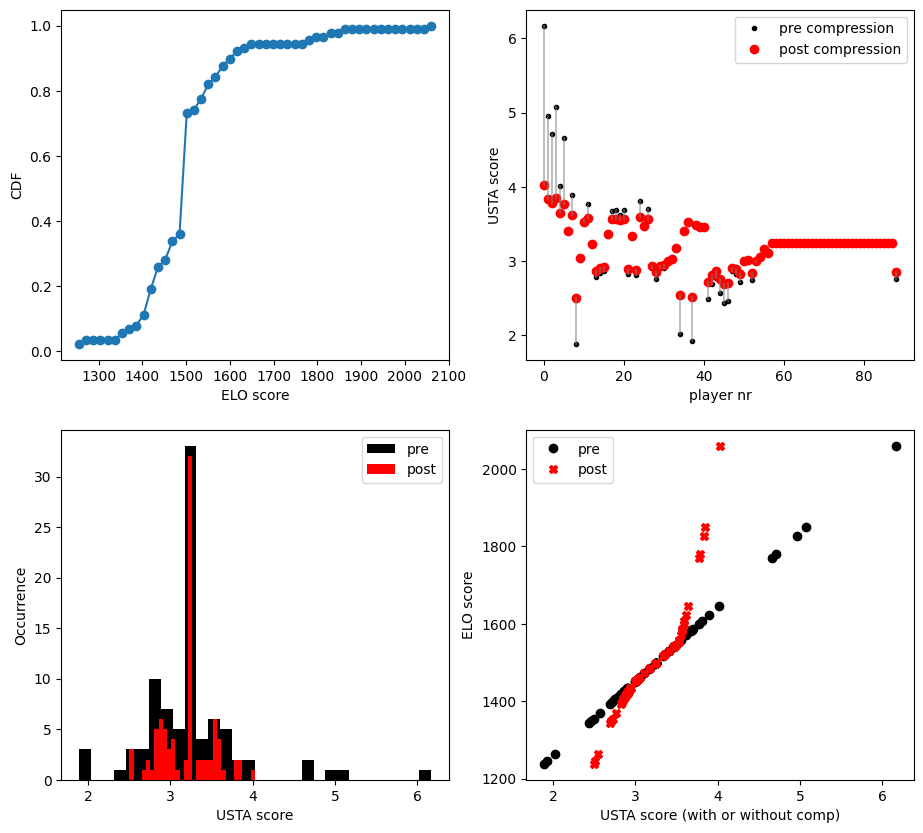

In [34]:
rankings, N = np.array(list(CE.elo.values())), len(CE.elo)

# Compute CDF of data
H, bin_edges = np.histogram(rankings, bins=50, density=True)
CDF = np.cumsum(H) * np.diff(bin_edges)[0]

# Map ELO to USTA
rank_usta = np.array(rankings, copy=True)
rank_usta /= rank_usta.std()  #scale  # 
rank_usta -= rank_usta.mean()
rank_usta += 3.0 + (3.5 - 3.0) / 2.0
# Use quantiles:
pc = .05
cutoff_dw, cutoff_up = norm.ppf([pc, 1-pc], loc=rank_usta.mean(), scale=rank_usta.std())
scale = cutoff_up - rank_usta.mean()
# Re-center distribution:
mu = rank_usta.mean()
rank_usta -= mu
rank_usta /= scale
rank_usta += mu
# Compress scores:
low_cutoff, hig_cutoff, map_to = 3.0, 3.5, 0.5
rank_usta_cmp = np.array(rank_usta, copy=True)
# High tail
x_ = rank_usta[rank_usta>hig_cutoff]
min_ = x_.min()
x_ = np.log10(x_ / min_)
x_ = (x_ / x_.max() * map_to) + min_
rank_usta_cmp[rank_usta_cmp>hig_cutoff] = x_
# Low tail
x_ = rank_usta[rank_usta<low_cutoff]
v_M, map_to = x_.max(), .5
x_ = 10**(x_ / x_.max() - 1)  #np.log10(vals / v_m)
x_ -= x_.min()
x_ = (low_cutoff-map_to) + x_ / x_.max() * map_to
rank_usta_cmp[rank_usta_cmp<low_cutoff] = x_


####### Plot
f, axs = plt.subplots(2, 2, figsize=(11, 10))
ax = axs[0][0]
ax.plot(bin_edges[1:], CDF, '-o')
ax.set_xlabel('ELO score'); ax.set_ylabel('CDF'); 
ax = axs[0][1]
ax.plot(rank_usta, '.k', label='pre compression');
ax.plot(rank_usta_cmp, 'or', label='post compression');
for k, (a, b) in enumerate(zip(rank_usta, rank_usta_cmp)):
    ax.plot([k, k], [a, b], '-', color=[.5,.5,.5,.5]);
ax.set_xlabel('player nr'); ax.set_ylabel('USTA score');
ax.legend();
ax = axs[1][0]
ax.hist(rank_usta, 30, facecolor='k', label='pre')
ax.hist(rank_usta_cmp, 30, facecolor='r', label='post')
ax.set_xlabel('USTA score'); ax.set_ylabel('Occurrence'); 
ax.legend();
ax = axs[1][1]
ax.plot(rank_usta, rankings, 'ok', label='pre')
ax.plot(rank_usta_cmp, rankings, 'Xr', label='post')
ax.set_xlabel('USTA score (with or without comp)'); 
ax.set_ylabel('ELO score'); ax.legend();